# DGL to make an invariant representation

In [1]:
import torch
from torch import nn
import dgl
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('data.csv')

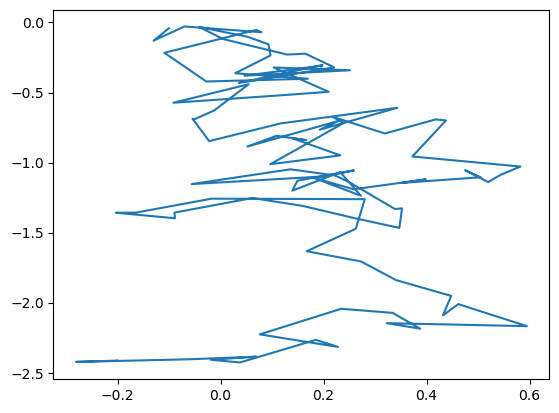

In [4]:
single_traj = data.iloc[:100].values
plt.plot(single_traj[:, 1], single_traj[:, 2])

## Build a graph from the data
- all time points should be connected to before and after
- points close in space, to some radius, should be connected

In [47]:
t = torch.from_numpy(single_traj[:,0]).reshape(-1,1).float()
r = torch.from_numpy(single_traj[:,1:]).float()
print(t.shape, r.shape)
print(t.dtype)

torch.Size([100, 1]) torch.Size([100, 2])
torch.float32


Start by creating graph from time alone

In [48]:
def graph_from_time(time_column_vector):
    n_nodes = len(time_column_vector)
    adjacency = np.eye(n_nodes, k=1, dtype=np.int32) + np.eye(n_nodes, k=-1, dtype=np.int32)
    src, dst = np.nonzero(adjacency)
    g = dgl.graph((src, dst))
    return g

In [49]:
g = graph_from_time(t)

In [50]:
g

Graph(num_nodes=100, num_edges=198,
      ndata_schemes={}
      edata_schemes={})

(-0.37259814828634263,
 0.6866999039053917,
 -2.6789200254529715,
 0.2231303327530623)

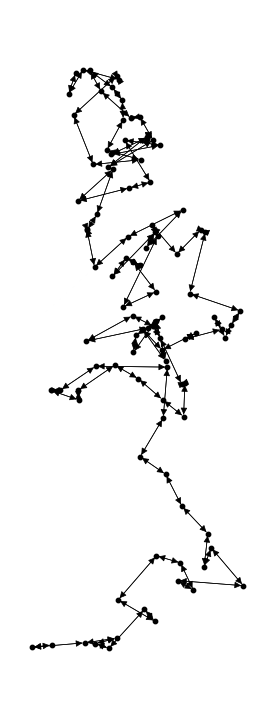

In [51]:
options = {
    'node_color': 'black',
    'node_size': 10,
    'width': 0.5,
}
G = dgl.to_networkx(g)
plt.figure(figsize=[7,7])
nx.draw(G, pos=r.numpy(), **options)
plt.axis('scaled')

Now one from radius

In [52]:
g = dgl.radius_graph(r, 0.1, p=2)

(-0.3712814125418663,
 0.6728428277373314,
 -2.6789200254529715,
 0.2231303327530623)

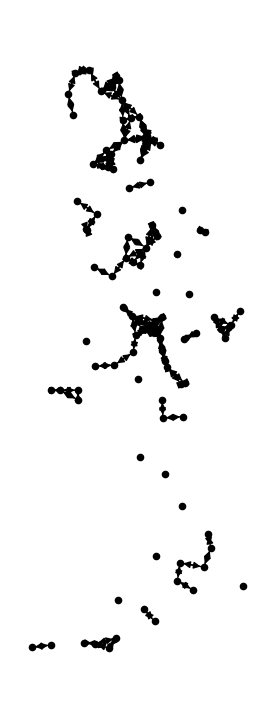

In [53]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'width': 1,
}
G = dgl.to_networkx(g)
plt.figure(figsize=[7,7])
nx.draw(G, pos=r.numpy(), **options)
plt.axis('scaled')

Put it together

In [54]:
def get_graph(time_tensor, xy_tensor, radius=0.1):
    g = dgl.radius_graph(xy_tensor, radius)
    tg = graph_from_time(time_tensor)
    g.add_edges(tg.edges()[0], tg.edges()[1])
    g = dgl.to_simple(g, return_counts=None)
    return g

In [55]:
g = get_graph(t, r)

(-0.37259814828634263,
 0.6866999039053917,
 -2.6789200254529715,
 0.2231303327530623)

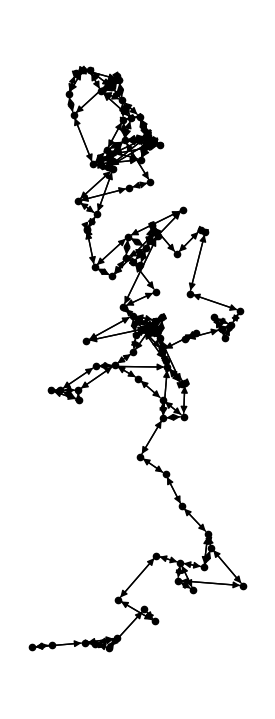

In [56]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'width': 1,
}
G = dgl.to_networkx(g)
plt.figure(figsize=[7,7])
nx.draw(G, pos=r.numpy(), **options)
plt.axis('scaled')

Yay!

## Attempt to pass the graph with data through an MPNN embedding layer

In [57]:
from dgl.nn.pytorch.conv.atomicconv import RadialPooling

In [63]:
class TrajEmbedd(nn.Module):
    """Embed trajectories of (t,x,y) into invariant edge and node features.
    
    Expects input node features "t" of shape (n_nodes, 1) and "xy" of shape (n_nodes, 2).
    Applies a radial basis function to node distances to get edge features.
    Applies linear layers and mean to get node features.
    """
    def __init__(self, filter_size: int = 5, hidden_size: int=16):

        super().__init__()

        # define space and time filter
        filter_vector = torch.rand(filter_size) + torch.tensor([0.1])
        self.distance_filter = RadialPooling(torch.clone(filter_vector), torch.clone(filter_vector), torch.clone(filter_vector))
        self.time_filter = RadialPooling(torch.clone(filter_vector), torch.clone(filter_vector), torch.clone(filter_vector))

        # embedding layer
        self.message_embedding = nn.Linear(int(2*filter_size), hidden_size)
    
    def get_distances(self, edges):
        # calculate element-wise euclidean distance
        xy_dists = (edges.src['xy'] - edges.dst['xy']).pow(2).sum(1).sqrt().reshape(-1,1)
        t_dists = (edges.src['t'] - edges.dst['t']).pow(2).sum(1).sqrt().reshape(-1,1)
        return {'r': xy_dists, 'dt': t_dists}
    
    def message(self, edges):
        return {'m': self.message_embedding(edges.data['he'])}

    def forward(self, g):
        with g.local_scope():
            # compute edge feature
            g.apply_edges(self.get_distances)
            g.edata['he'] = torch.cat(
                [
                    self.distance_filter(g.edata['r']).transpose(0,1),
                    self.time_filter(g.edata['dt']).transpose(0,1)
                ],
                dim=1).squeeze(dim=2)
            
            # compute node feature
            g.update_all(message_func=self.message, reduce_func=dgl.function.mean('m', 'hn'))
            return g, g.ndata['hn'], g.edata['he']

In [64]:
embedder = TrajEmbedd()

In [65]:
g = get_graph(t, r)

In [66]:
g.ndata['t'] = t
g.ndata['xy'] = r
g

Graph(num_nodes=100, num_edges=400,
      ndata_schemes={'t': Scheme(shape=(1,), dtype=torch.float32), 'xy': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})

In [68]:
g, ndata, edata = embedder(g)

In [69]:
ndata.shape

torch.Size([100, 16])

In [70]:
edata.shape

torch.Size([400, 10])

## Skip the convolutional layers for now, let's pool the output to confirm that the network is equivariant to time translation, xy rotationa nd translation

In [81]:
t_translated = t - 0.5
xy_translated = r - 0.5

In [82]:
theta = 0.5 * np.pi
xy_rotated = torch.matmul(r, torch.tensor([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]).float())

### base output

In [83]:
pooler = dgl.nn.WeightAndSum(16)

In [85]:
g.ndata['t'] = t
g.ndata['xy'] = r
g, ndata, edata = embedder(g)
out = pooler(g, ndata)

### time translation

In [86]:
g.ndata['t'] = t_translated
g.ndata['xy'] = r
g, ndata, edata = embedder(g)
out_time_trans = pooler(g, ndata)

### xy translated

In [87]:
g.ndata['t'] = t
g.ndata['xy'] = xy_translated
g, ndata, edata = embedder(g)
out_xy_trans = pooler(g, ndata)

### xy rotated

In [88]:
g.ndata['t'] = t
g.ndata['xy'] = xy_rotated
g, ndata, edata = embedder(g)
out_xy_rot = pooler(g, ndata)

### check invariance

In [98]:
print(torch.isclose(out, out_time_trans).all())
print(torch.isclose(out, out_xy_trans).all())
print(torch.isclose(out, out_xy_rot).all())

tensor(True)
tensor(True)
tensor(True)


## Embedding is invariant. Try convolving